In [1]:
import numpy as np
from scipy import linalg
import scipy.sparse as sp
import scipy.sparse.linalg
from tqdm import tqdm
import matplotlib.pyplot as plt

from pyps import Basis, Hamiltonian
from pyps.constants import e, a0, En_h

In [2]:
H = Hamiltonian(Basis(n_values=range(30, 40), MJ_values=[0]), sparse_format="csr")

# pre-compute Stark matrix
H.stark_matrix(numerov=True)

calculate Stark terms (numerov): 100%|██████████| 1360/1360 [00:32<00:00, 41.72it/s] 


<1360x1360 sparse matrix of type '<class 'numpy.float64'>'
	with 31900 stored elements in Compressed Sparse Row format>

diagonalise matrix: 100%|██████████| 20/20 [00:06<00:00,  2.98it/s]


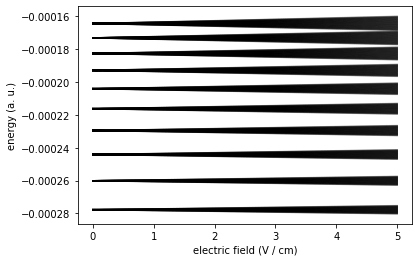

In [3]:
field = np.linspace(0.0, 5.0, 20)  # V/cm

sm = H.stark_map(100.0 * field)

# plot
for level in sm.T:
    plt.plot(field, level, c="k", alpha=0.1)

plt.xlabel("electric field (V / cm)")
plt.ylabel("energy (a. u.)")
plt.show()

Running `H.stark_map()` is essentially equivilent to: 

100%|██████████| 20/20 [00:06<00:00,  3.28it/s]


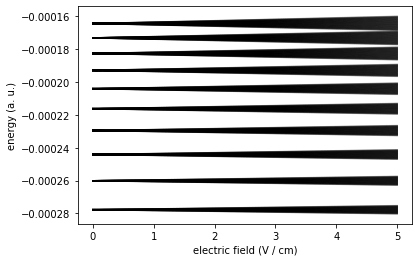

In [4]:
field_au = 100.0 * field * e * a0 / En_h  # atomic units

stark_map = np.array(
    [linalg.eigvalsh(H.matrix(Fz=f).toarray()) for f in tqdm(field_au)]
)

# plot
for level in stark_map.T:
    plt.plot(field, level, c="k", alpha=0.1)

plt.xlabel("electric field (V / cm)")
plt.ylabel("energy (a. u.)")
plt.show()

In [5]:
%timeit linalg.eigvalsh(H.matrix(Fz=2.5e-10).toarray())

304 ms ± 56.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Sometimes a large basis is required to get accurate energy levels, even if only a fraction of the eigenvalues are of interest. Fortunately, it is possible to compute a subset of the eignevalues, which is often a little faster.  Moreover, the total Hamiltonian matrix can remain sparse, potentially saving a lot of memory. 

100%|██████████| 20/20 [00:03<00:00,  6.61it/s]


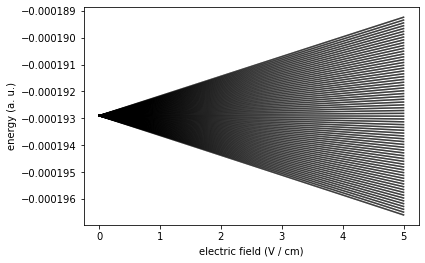

In [6]:
subset = list(H.basis.argwhere(lambda x: x.n == 36))
k = len(subset)
sigma = np.median(H.e0[subset])

sparse_map = np.array(
    [
        sp.linalg.eigsh(H.matrix(Fz=f), k=k, sigma=sigma, return_eigenvectors=False)
        for f in tqdm(field_au)
    ]
)

# plot
for level in sparse_map.T:
    plt.plot(field, level, c="k", alpha=0.5)

plt.xlabel("electric field (V / cm)")
plt.ylabel("energy (a. u.)")
plt.show()

(The above calculation can probably be sped up by moving some of the shift-inversion steps outside of the loop.)

Compare sparse and dense calculations:

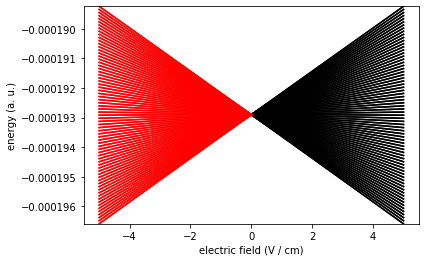

In [7]:
# dense
for i in subset:
    plt.plot(field, stark_map[:, i], c="k")

# sparse
for level in sparse_map.T:
    plt.plot(-field, level, c="r")

plt.ylim(np.min(sparse_map), np.max(sparse_map))
plt.xlabel("electric field (V / cm)")
plt.ylabel("energy (a. u.)")
plt.show()

If the subset contains a partial $n$ manifold, exactly which eigenvalues are computed can vary abruptly from one field to the next.  This can get confusing when attempting to trace states through crossings.

100%|██████████| 20/20 [00:00<00:00, 34.06it/s]


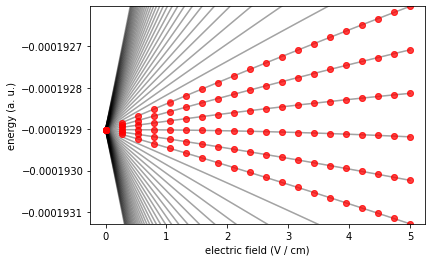

In [8]:
k = 12
sparse_map_12 = np.array(
    [
        sp.linalg.eigsh(H.matrix(Fz=f), k=k, sigma=sigma, return_eigenvectors=False)
        for f in tqdm(field_au)
    ]
)


# dense
for i in subset:
    plt.plot(field, stark_map[:, i], c="k", alpha=0.2)

# sparse
for level in sparse_map_12.T:
    plt.plot(field, level, c="r", ls="", marker="o", alpha=0.5)

plt.ylim(np.min(sparse_map_12), np.max(sparse_map_12))
plt.xlabel("electric field (V / cm)")
plt.ylabel("energy (a. u.)")
plt.show()

In [9]:
%timeit sp.linalg.eigsh(H.matrix(Fz=2.5e-10), k=k, sigma=sigma, return_eigenvectors=False)

21.4 ms ± 1.33 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
